In [38]:
import pandas as pd
import numpy as np
import yfinance as yf
import os
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.stats import t
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

In [23]:
# path = 'C:/Users/Janet/OneDrive - The University of Chicago/Data_policy/final-project-janet'

# file_name = 'combined_stock_data.csv'
# file_path = os.path.join(path, file_name)
# df = pd.read_csv(file_path)
# df['date'] = pd.to_datetime(df['date'])
# df.set_index('date', inplace=True)
path = 'C:/Users/Janet/OneDrive - The University of Chicago/Data_policy/final-project-janet'
file_name = 'combined_stock_data.csv'
file_path = os.path.join(path, file_name)
df = pd.read_csv(file_path)

In [57]:
#summary stats
print(df.describe())

non_zero_dividends = df[df['dividends'] != 0]

# Count the unique stocks in the filtered DataFrame
unique_stocks_count = non_zero_dividends['ticker'].unique()

print(unique_stocks_count)

print(non_zero_dividends.describe())

                                date    stock_open    stock_high  \
count                          62359  6.235900e+04  6.235900e+04   
mean   2018-01-02 18:03:10.856171520  1.977700e+02  2.018739e+02   
min              2017-06-28 00:00:00  1.000000e-06  1.000000e-06   
25%              2017-10-02 00:00:00  8.800000e-01  9.000000e-01   
50%              2018-01-04 00:00:00  1.205000e+01  1.225000e+01   
75%              2018-04-09 00:00:00  4.065375e+01  4.099000e+01   
max              2018-07-06 00:00:00  2.290000e+04  2.425000e+04   
std                              NaN  1.483422e+03  1.514584e+03   

          stock_low   stock_close  stock_adj_close  stock_volume  \
count  6.235900e+04  6.235900e+04     62359.000000  6.235900e+04   
mean   1.934728e+02  1.980472e+02       187.802599  1.572620e+06   
min    1.000000e-06  1.000000e-06        -3.402873  0.000000e+00   
25%    8.800000e-01  8.800000e-01         0.775000  0.000000e+00   
50%    1.187000e+01  1.206000e+01         9.718

In [53]:



df['date'] = pd.to_datetime(df['date'])

# Calculating daily returns for stocks and the market
df['stock_return'] = df.groupby('ticker')['stock_adj_close'].pct_change()
df['market_return'] = df['market_adj_close'].pct_change()

# Define the event date and event window
event_date = datetime(2018, 6, 28)
window_start = event_date - timedelta(days=5)
window_end = event_date + timedelta(days=5)

# Filter data for the event window
event_window_data = df[(df['date'] >= window_start) & (df['date'] <= window_end)]

# Function to estimate parameters (alpha and beta) for each stock
def estimate_parameters(ticker, data):
    stock_data = data[data['ticker'] == ticker].dropna()
    if len(stock_data) < 2:  # Ensure there's enough data
        return np.nan, np.nan
    X = sm.add_constant(stock_data['market_return'])  # Adding a constant for the intercept (alpha)
    model = sm.OLS(stock_data['stock_return'], X).fit()
    return model.params

# Estimate parameters for each stock
parameters = {ticker: estimate_parameters(ticker, df) for ticker in df['ticker'].unique()}

# Calculate expected returns for each stock in the event window
def calculate_expected_return(row, params):
    alpha, beta = params.get(row['ticker'], (np.nan, np.nan))
    if pd.isna(alpha) or pd.isna(beta):  # Handle missing alpha or beta
        return np.nan
    return alpha + beta * row['market_return']

event_window_data['expected_return'] = event_window_data.apply(lambda row: calculate_expected_return(row, parameters), axis=1)

# Calculate abnormal returns
event_window_data['abnormal_return'] = event_window_data['stock_return'] - event_window_data['expected_return']

# Results
event_window_data[['date', 'ticker', 'stock_return', 'market_return', 'expected_return', 'abnormal_return']]


C:\Users\Janet\AppData\Local\Temp\ipykernel_29312\3300613522.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  event_window_data['expected_return'] = event_window_data.apply(lambda row: calculate_expected_return(row, parameters), axis=1)
C:\Users\Janet\AppData\Local\Temp\ipykernel_29312\3300613522.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  event_window_data['abnormal_return'] = event_window_data['stock_return'] - event_window_data['expected_return']


,date,ticker,stock_return,market_return,expected_return,abnormal_return
60099,2018-06-25,SAYFF,0.000000,-0.013725,0.000286,-0.000286
60100,2018-06-25,FRRFF,0.000000,0.000000,0.000480,-0.000480
60101,2018-06-25,ABM,-0.011483,0.000000,-0.001061,-0.010422
60102,2018-06-25,ACN,-0.021738,0.000000,0.001251,-0.022988
60103,2018-06-25,AHEXF,-0.017753,0.000000,-0.000672,-0.017080
...,...,...,...,...,...,...
61852,2018-07-03,APVS,0.000000,0.000000,0.001591,-0.001591
61853,2018-07-03,ASFT,0.000000,0.000000,-0.005463,0.005463
61854,2018-07-03,APCX,0.000000,0.000000,0.016838,-0.016838
61855,2018-07-03,APYP,0.000000,0.000000,0.012976,-0.012976


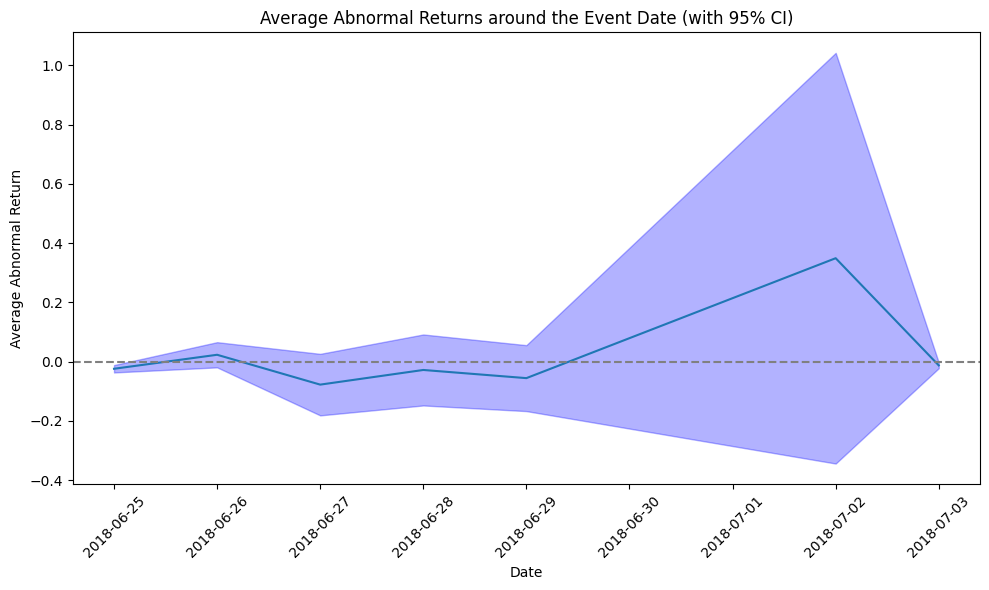

In [46]:



# Group by date and calculate the mean and standard deviation of abnormal returns for each day
daily_stats = event_window_data.groupby('date')['abnormal_return'].agg(['mean', 'std']).reset_index()

# Calculate the number of observations per day
daily_counts = event_window_data.groupby('date')['abnormal_return'].count().reset_index(name='count')


daily_stats = pd.merge(daily_stats, daily_counts, on='date')

# Calculate the standard error of the mean
daily_stats['sem'] = daily_stats['std'] / np.sqrt(daily_stats['count'])

# Plotting
plt.figure(figsize=(10, 6))
sns.lineplot(x='date', y='mean', data=daily_stats)

# Add shaded region for confidence interval (95% CI)
plt.fill_between(
    daily_stats['date'], 
    daily_stats['mean'] - 1.96 * daily_stats['sem'],  
    daily_stats['mean'] + 1.96 * daily_stats['sem'], 
    color='blue', alpha=0.3
)

plt.axhline(0, color='grey', linestyle='--')  
plt.title('Average Abnormal Returns around the Event Date (with 95% CI)')
plt.xlabel('Date')
plt.ylabel('Average Abnormal Return')
plt.xticks(rotation=45)  
plt.tight_layout()  
plt.show()


In [ ]:

# Define the stock and market index
stock_ticker = 'AAPL'  # Example: Apple Inc.
market_index_ticker = '^GSPC'  # Example: S&P 500

# Define the event date and windows
event_date = datetime(2020, 1, 1)
estimation_window_start = event_date - timedelta(days=365)
estimation_window_end = event_date - timedelta(days=30)
event_window_start = event_date - timedelta(days=10)
event_window_end = event_date + timedelta(days=10)

# Fetch historical data
stock_data = yf.download(stock_ticker, start=estimation_window_start, end=event_window_end)
market_data = yf.download(market_index_ticker, start=estimation_window_start, end=event_window_end)



